In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from openmm import app
import openmm as mm
import openmm.unit as unit
import openmmtools

import openpathsampling as paths
import openpathsampling.engines.openmm as ops_openmm
from openpathsampling.engines.openmm.tools import ops_load_trajectory
import openpathsampling.visualize as ops_vis

import mdtraj as md
import pyemma as pm

from pathlib import Path
import os
import pickle
import pandas 
from IPython.display import SVG

In [2]:
seed = 49587
rng = np.random.default_rng(seed)

# Paths
top_path = './data/CLN/protein.pdb'
traj_paths = [str(x) for x in Path(r'./data/CLN').rglob(f'CLN025-0-protein-*.xtc')]
md_gro_path = './data/init_paths/CLN_md/nvt.gro'
md_top_path = './data/init_paths/CLN_md/topol.top'
traj_paths.sort()

# MSM parameters
f_scheme = 'ca'
tica_lag = 3
tica_d = 15
cluster_n = 469
cluster_stride = 1
max_iter = 1000
msm_lag = 31

# PCCA+ parameters
n_sets = 2
core_membership_cutoff = 0.9

In [3]:
# MSM
ftrajs = []
for traj_path in traj_paths:
    traj = md.load(traj_path, top=top_path)
    ftrajs.append(md.compute_contacts(traj, scheme=f_scheme)[0])
ftrajs_cat = np.concatenate(ftrajs)

tica_mod = pm.coordinates.tica(ftrajs, lag=tica_lag, dim=tica_d, kinetic_map=True)
ttrajs = tica_mod.get_output()

kmeans_mod = pm.coordinates.cluster_kmeans(ttrajs, k=cluster_n, max_iter=max_iter, stride=cluster_stride, fixed_seed=seed)
dtrajs = kmeans_mod.dtrajs

msm = pm.msm.estimate_markov_model(dtrajs, lag=msm_lag)
_ = msm.pcca(n_sets)

/home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


calculate covariances:   0%|          | 0/54 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/54 [00:00<?, ?it/s]

/home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/ops/lib/python3.8/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/469 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
ttrajs_cat = np.concatenate(ttrajs)

with sns.plotting_context('paper',font_scale=1.5):
    fig, ax = plt.subplots(figsize=(20, 4))
    
    ax.plot(ttrajs_cat[:,0], lw=0.4, label='IC1')
    ax.set_xlim([0, ttrajs_cat.shape[0]])
    
    for i in range(0, len(ftrajs_cat), 2000):
        ax.axvline(i, ls='--', lw=1.5, c='gray', alpha=0.8)

In [ ]:
with sns.plotting_context('paper',font_scale=1.5):
    fig, ax = plt.subplots(figsize=(20, 4))
    
    ax.plot(ttrajs[3][:,0], lw=0.4, label='IC1')
    ax.set_xlim([850, 900])

In [ ]:
# Initial path from md

t_traj = md.load(traj_paths[3], top=top_path)
transition_traj = t_traj[850:890]
transition_traj.superpose(transition_traj[0])
transition_traj.save(r'./data/init_paths/CLN_md.xtc')

In [4]:
# Define CVs

def tica_cv(snapshot, tica_mod, f_scheme):
    f_snapshot = md.compute_contacts(snapshot, scheme=f_scheme)[0]
    tica_snapshot = tica_mods.transform(f_snapshot)
    return tica_cv

tica = paths.FunctionCV("tica_cv", tica_cv, 
                           tica_mod=tica_mod)

# Import libraries again as the function can't access global variables
def pcca_cv(snapshot, tica_mod, kmeans_mod, msm, f_scheme):
    import openpathsampling as paths
    import mdtraj as md
    traj = paths.engines.Trajectory([snapshot]).to_mdtraj()
    f_traj = md.compute_contacts(traj, scheme=f_scheme)[0]
    tica_traj = tica_mod.transform(f_traj)
    microstate = kmeans_mod.assign(tica_traj)
    pcca = msm.metastable_memberships[microstate].flatten()
    return pcca[0]

pcca = paths.FunctionCV("pcca_cv", pcca_cv, 
                        tica_mod=tica_mod,
                        kmeans_mod=kmeans_mod,
                        msm=msm,
                        cv_time_reversible=True,
                        f_scheme=f_scheme)

In [5]:
# Define metastable states hypervolumes
pcca_0_vol = paths.volume.CVDefinedVolume(pcca, lambda_min=0.95, lambda_max=1.00)
pcca_1_vol = paths.volume.CVDefinedVolume(pcca, lambda_min=0.00, lambda_max=0.05)

In [6]:
gro = app.GromacsGroFile(md_gro_path)
# Gmx topology only stores reference to ff definitions. Need to specifty the directory contains ff files.
top = app.GromacsTopFile(md_top_path, 
                         periodicBoxVectors=gro.getPeriodicBoxVectors(),
                         includeDir=r'/home/rzhu/Loc/gromacs/share/gromacs/top')

# Create system from gmx files
system = top.createSystem(nonbondedMethod=app.PME, 
                          nonbondedCutoff=1.0*unit.nanometers,
                          constraints=app.HBonds, 
                          rigidWater=True,
                          ewaldErrorTolerance=0.0005)

# Velocity-Verlet with Velocity Randomisation Integrator that simulates Langvein dynamics
integrator = openmmtools.integrators.VVVRIntegrator(
    # Temperature
    300*unit.kelvin,
    # Collision rate (temperature coupling time constant)
    1.0/unit.picoseconds,
    # Timestep
    2.0*unit.femtoseconds
)
integrator.setConstraintTolerance(0.00001)

In [ ]:
# in case i want to run simulations in open mm
simulation = app.Simulation(top.topology, system, integrator)
simulation.context.setPositions(gro.positions)
simulation.reporters.append(app.PDBReporter('output.pdb', 1000))
simulation.minimizeEnergy()

In [7]:
openmm_properties = {}
engine_options = {
    # Maximal frames per trajectory 100 ns
    'n_frames_max': 100000,
    # Time interval between frames = 1 ps
    'n_steps_per_frame': 500
}
ops_topology = ops_openmm.tools.topology_from_pdb(md_gro_path)
engine = ops_openmm.Engine(
    topology=ops_topology, 
    system=system, 
    integrator=integrator, 
    openmm_properties=openmm_properties,
    options=engine_options
).named('CLN_Openmm_engine')

In [8]:
# Define the path ensemble to be sampled from
network = paths.TPSNetwork(initial_states=pcca_0_vol, final_states=pcca_1_vol)
# Define shooting scheme. A shooting move scheme can contains multiple shooting strategies 
scheme = paths.OneWayShootingMoveScheme(network=network, 
                                        selector=paths.UniformSelector(),
                                        engine=engine).named("CLN_scheme")

In [9]:
# Load initial trajectory from external files
init_traj = ops_load_trajectory(r'./data/init_paths/CLN_md/md_1us.xtc', top=r'./data/init_paths/CLN_md/nvt.gro')
initial_conditions = scheme.initial_conditions_from_trajectories(init_traj)

No missing ensembles.
No extra ensembles.


In [10]:
storage = paths.Storage(r"./data/CLN_tps_test.nc", "w", template=init_traj[0])

In [12]:
sampler = paths.PathSampling(storage=storage,
                             move_scheme=scheme,
                             sample_set=initial_conditions)

In [13]:
sampler.run(50)

Working on Monte Carlo cycle number 50
Running for 12 seconds -  0.26 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 50 Monte Carlo cycles.


In [14]:
storage.close()

In [15]:
storage = paths.AnalysisStorage(r"./data/CLN_tps_test.nc")

In [16]:
scheme = storage.schemes[0]  # only one in there
scheme.move_summary(storage.steps)

  0%|          | 0/51 [00:00<?, ?it/s]

shooting ran 100.000% (expected 100.00%) of the cycles with acceptance 0/50 (0.00%)


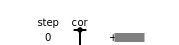

In [23]:
tree = ops_vis.PathTree(
    storage.steps,
    ops_vis.ReplicaEvolution(replica=0)
)

SVG(tree.svg())

In [22]:
import openpathsampling.visualize as ops_vis
from IPython.display import SVG